In [ ]:
#pip install foolbox==1.8.0

Я не сделал сравнение с foolbox, к сожалению((

Я побоялся разбираться с их парсингом и/или переписсывать для нормальной загрузки датасета, типа MNIST или CIFAR.

У них используется старый фулбокс, правда он нигде вроде не применяется, поэтому если просто закомментить ниже

'''
resnet50 = torch_models.resnet50(pretrained=True).eval()
if torch.cuda.is_available():
    resnet50 = resnet50.cuda()
meanfb = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
stdfb = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
fmodel = foolbox.models.PyTorchModel(
    resnet50, bounds=(0, 1), num_classes=1000, preprocessing=(meanfb, stdfb))
'''

то все должно работать.

Также есть две строчки


#label_HSJA = np.argmax(fmodel.forward_one(image_fb_first))

#str_HSJA_ground = get_label(labels[np.int(label_HSJA)].split(',')[0])

с интересным нам методом HSJA из одной из четырех статей. Правда по виду это просто фулбокс. Но они нигде не применяются тоже, а что такое forward_one я так и не понял, оно выдает ошибки

In [1]:
%matplotlib inline

import torch.nn as nn
import torchvision.datasets as dsets

import torchvision.transforms as transforms
import torchvision.models as torch_models
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from utils import    get_label
from utils import valid_bounds, clip_image_values
from PIL import Image
from torch.autograd import Variable
from numpy import linalg 
import foolbox 
import math
from generate_2d_dct_basis import *
import time
import pretrainedmodels

In [2]:
# Parameters 


grad_estimator_batch_size = 40     # batch size for GeoDA


verbose_control = 'Yes'
#verbose_control = 'No'



Q_max = 4000

torch.manual_seed(992)
torch.cuda.manual_seed(992)
np.random.seed(992)

sub_dim=75

tol = 0.0001
sigma = 0.0002
mu = 0.6


#dist = 'l2'
dist = 'linf'
dist = 'l1'
dist = 'linf'
dist = 'l2'
search_space = 'sub'



image_iter = 0


image_num = 64
image_num = 1069

#inp = "./data/ILSVRC2012_val_000000" + str(image_num) + ".JPEG"

inp = "./data/ILSVRC2012_val_0000" + str(image_num) + ".JPEG"
#inp = "./data/ILSVRC2012_val_00000009.JPEG"
#ILSVRC2012_val_00001069.JPEG
#inp = "./data/img.JPEG"


In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
    
    
def inv_tf(x, mean, std):

    for i in range(len(mean)):

        x[i] = np.multiply(x[i], std[i], dtype=np.float32)
        x[i] = np.add(x[i], mean[i], dtype=np.float32)

    x = np.swapaxes(x, 0, 2)
    x = np.swapaxes(x, 0, 1)

    return x


def from_np_to_01(imnp):
    im01 = inv_tf(imnp.cpu().numpy().squeeze(), mean, std)
    im01= np.transpose(im01, (2, 0, 1))
    return im01

In [4]:
def topk_3D (grad, k):   
    
    
    grad_flatten = grad.cpu().numpy().reshape(-1)
    grad_flatten_torch = torch.tensor(grad_flatten)
    topk, indices = torch.topk(torch.abs(grad_flatten_torch), k)
    #grad_k_flatten = torch.zeros([2*4*3])

    grad_k_flatten = torch.zeros([224*224*3])

    for ind in indices:
        
        grad_k_flatten[ind] = grad_flatten[ind] + 0

    grad_k_flatten_np = grad_k_flatten.cpu().numpy()
    
    #grad_k_3D_np = np.reshape(grad_k_flatten_np, ( 3, 2, 4))

    grad_k_3D_np = np.reshape(grad_k_flatten_np, ( 3, 224, 224))

    grad_3D_torch = torch.tensor(grad_k_3D_np)
    grad_3D_sign = torch.sign(grad_3D_torch)


    return grad_3D_sign

In [5]:

def is_adversarial(given_image, orig_label):
    
    predict_label = torch.argmax(net.forward(Variable(given_image, requires_grad=True)).data).item()

    return predict_label != orig_label

def find_random_adversarial(image, epsilon=1000):

    num_calls = 1
    
    step = 0.02
    perturbed = x_0
    
    while is_adversarial(perturbed, orig_label) == 0:
        
        pert = torch.randn([1,3,224,224])
        pert = pert.to(device)

        perturbed = image + num_calls*step* pert
        perturbed = clip_image_values(perturbed, lb, ub)
        perturbed = perturbed.to(device)
        num_calls += 1
        
    return perturbed, num_calls 

def bin_search(x_0, x_random, tol):

    
    num_calls = 0
    adv = x_random
    cln = x_0
    
    while True:
        
        mid = (cln + adv) / 2.0
        num_calls += 1
        
        if is_adversarial(mid, orig_label):
            adv = mid
        else:
            cln = mid

        if torch.norm(adv-cln).cpu().numpy()<tol:
            break

    return adv, num_calls 


def black_grad_batch(x_boundary, q_max, sigma, random_noises, batch_size, original_label):
    
    grad_tmp = [] # estimated gradients in each estimate_batch
    z = []        # sign of grad_tmp
    outs = []
    num_batchs = math.ceil(q_max/batch_size)
    last_batch = q_max - (num_batchs-1)*batch_size
    EstNoise = SubNoise(batch_size, sub_basis_torch).cuda()
    all_noises = []
    for j in range(num_batchs):
        if j == num_batchs-1:
            EstNoise_last = SubNoise(last_batch, sub_basis_torch).cuda()
            current_batch = EstNoise_last()
            current_batch_np = current_batch.cpu().numpy()
            noisy_boundary = [x_boundary[0,:,:,:].cpu().numpy()]*last_batch +sigma*current_batch.cpu().numpy()

        else:
            current_batch = EstNoise()
            current_batch_np = current_batch.cpu().numpy()
            noisy_boundary = [x_boundary[0,:,:,:].cpu().numpy()]*batch_size +sigma*current_batch.cpu().numpy()
        
        all_noises.append(current_batch_np) 
        
        noisy_boundary_tensor = torch.tensor(noisy_boundary).to(device)
        
        predict_labels = torch.argmax(net.forward(noisy_boundary_tensor),1).cpu().numpy().astype(int)
        
        
        outs.append(predict_labels)
    all_noise = np.concatenate(all_noises, axis=0)
    outs = np.concatenate(outs, axis=0)
        

    for i, predict_label in enumerate(outs):
        if predict_label == original_label:
            z.append(1)
            grad_tmp.append(all_noise[i])
        else:
            z.append(-1)
            grad_tmp.append(-all_noise[i])
    
    grad = -(1/q_max)*sum(grad_tmp)
    
    grad_f = torch.tensor(grad).to(device)[None, :,:,:]

    return grad_f, sum(z)

In [6]:
def go_to_boundary(x_0, grad, x_b):

    epsilon = 5

    num_calls = 1
    perturbed = x_0 

    if dist == 'l1' or dist == 'l2':
        
        grads = grad


    if dist == 'linf':
        
        grads = torch.sign(grad)/torch.norm(grad)

        
        
    while is_adversarial(perturbed, orig_label) == 0:

        perturbed = x_0 + (num_calls*epsilon* grads[0])
        perturbed = clip_image_values(perturbed, lb, ub)

        num_calls += 1
        
        if num_calls > 100:
            print('falied ... ')
            break
        print
    return perturbed, num_calls, epsilon*num_calls 


def GeoDA(x_b, iteration, q_opt):
    
   
    norms = []
    q_num = 0
    grad = 0
    
    for i in range(iteration):
    
        t1 = time.time()
        random_vec_o = torch.randn(q_opt[i],3,224,224)

        grad_oi, ratios = black_grad_batch(x_b, q_opt[i], sigma, random_vec_o, grad_estimator_batch_size , orig_label)
        q_num = q_num + q_opt[i]
        grad = grad_oi + grad
        x_adv, qs, eps = go_to_boundary(x_0, grad, x_b)
        q_num = q_num + qs
        x_adv, bin_query = bin_search(x_0, x_adv, tol)


        q_num = q_num + bin_query

        x_b = x_adv
        
        t2 = time.time()
        x_adv_inv = inv_tf(x_adv.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
        
        if dist == 'l1' or dist == 'l2':
            dp = 'l2'
            norm_p = linalg.norm(x_adv_inv-image_fb)
            
            
        if dist == 'linf':
            dp = dist

            norm_p = np.max(abs(x_adv_inv-image_fb))
        
        if verbose_control == 'Yes':
            message = ' (took {:.5f} seconds)'.format(t2 - t1)
            print('iteration -> ' + str(i) + str(message) + '     -- ' + dp + ' norm is -> ' + str(norm_p))
        norms.append(norm_p)
        
        
    x_adv = clip_image_values(x_adv, lb, ub)
        
    return x_adv, q_num, grad, norms



In [7]:
def opt_query_iteration(Nq, T, eta): 

  
    
    coefs=[eta**(-2*i/3) for i in range(0,T)]
    coefs[0] = 1*coefs[0]
    
    sum_coefs = sum(coefs)
    opt_q=[round(Nq*coefs[i]/sum_coefs) for i in range(0,T)]
    
    if opt_q[0]>80:
        T = T + 1
        opt_q, T = opt_query_iteration(Nq, T, eta)
    elif opt_q[0]<50:
        T = T - 1

        opt_q, T = opt_query_iteration(Nq, T, eta)

    return opt_q, T

def uni_query(Nq, T, eta): 

    opt_q=[round(Nq/T) for i in range(0,T)]
      
        
    return opt_q


In [8]:
def load_image(image, shape=(224, 224), data_format='channels_last'):

    assert len(shape) == 2
    assert data_format in ['channels_first', 'channels_last']

    
    image = image.resize(shape)
    image = np.asarray(image, dtype=np.float32)
    image = image[:, :, :3]
    assert image.shape == shape + (3,)
    if data_format == 'channels_first':
        image = np.transpose(image, (2, 0, 1))
    return image

In [9]:
class SubNoise(nn.Module):
    """given subspace x and the number of noises, generate sub noises"""
    # x is the subspace basis
    def __init__(self, num_noises, x):
        self.num_noises = num_noises
        self.x = x
        super(SubNoise, self).__init__()

    def forward(self):
        

        r = torch.zeros([224 ** 2, 3*self.num_noises], dtype=torch.float32)
        noise = torch.randn([self.x.shape[1], 3*self.num_noises], dtype=torch.float32).cuda()
        sub_noise = torch.transpose(torch.mm(self.x, noise), 0, 1)
        r = sub_noise.view([ self.num_noises, 3, 224, 224])

        r_list = r
        return r_list

In [10]:
#sub_basis = np.load('2d_dct_basis_{}.npy'.format(sub_dim), allow_pickle=True).astype(np.float32)

In [11]:
sub_dim = 75

In [12]:
if search_space == 'sub':
    print('Check if DCT basis available ...')
    
    #path = os.path.join(os.path.dirname(__file__), '2d_dct_basis_{}.npy'.format(sub_dim))
    path = '2d_dct_basis_{}.npy'.format(sub_dim)
    #path = os.path.join(os.path.dirname(dirname), '2d_dct_basis_{}.npy'.format(sub_dim))
    if os.path.exists(path):
        print('Yes, we already have it ...')
        sub_basis = np.load('2d_dct_basis_{}.npy'.format(sub_dim), allow_pickle=True).astype(np.float32)
    else:
        print('Generating dct basis ......')
        sub_basis = generate_2d_dct_basis(sub_dim).astype(np.float32)
        print('Done!\n')


    estimate_batch = grad_estimator_batch_size
    sub_basis_torch = torch.from_numpy(sub_basis).cuda()
    EstNoise = SubNoise(estimate_batch, sub_basis_torch).cuda()
    random_vectors = EstNoise()
    random_vectors_np = random_vectors.cpu().numpy()
    

Check if DCT basis available ...
Yes, we already have it ...


In [ ]:
!nvidia-smi

In [37]:
'''
resnet50 = torch_models.resnet50(pretrained=True).eval()
#if torch.cuda.is_available():
#    resnet50 = resnet50.cuda()

device = 'cuda:7' if torch.cuda.is_available() else 'cpu'
resnet50 = resnet50.to(device)
meanfb = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
stdfb = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)

fmodel = foolbox.models.PyTorchModel(resnet50, bounds=(0, 1), preprocessing=preprocessing)


device = 'cuda:7' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
net = torch_models.resnet50(pretrained=True)
net = net.to(device)
net.eval()
'''

In [15]:
#pip show foolbox

Name: foolbox
Version: 1.8.0
Summary: Python toolbox to create adversarial examples that fool neural networks
Home-page: https://github.com/bethgelab/foolbox
Author: Jonas Rauber & Wieland Brendel
Author-email: opensource@bethgelab.org
License: MIT
Location: /opt/conda/lib/python3.6/site-packages
Requires: requests, GitPython, numpy, scipy, setuptools
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [14]:
resnet50 = torch_models.resnet50(pretrained=True).eval()
if torch.cuda.is_available():
    resnet50 = resnet50.cuda()
meanfb = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
stdfb = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
fmodel = foolbox.models.PyTorchModel(
    resnet50, bounds=(0, 1), num_classes=1000, preprocessing=(meanfb, stdfb))



# Check for cuda devices
device = 'cuda:6' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
net = torch_models.resnet50(pretrained=True)
net = net.to(device)
net.eval()

#model_name = 'inceptionresnetv2' #'nasnetalarge' # could be fbresnet152 or inceptionresnetv2
#net = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
#net = net.to(device)
#net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
#net = torchvision.models.alexnet(pretrained=True)
#net = net.to(device)
#net.eval()

In [16]:
#device = 'cuda:6' if torch.cuda.is_available() else 'cpu'
#net = torch_models.resnet50(pretrained=True)
#net = net.to(device)
#net.eval()


In [37]:
image_num = 9
#image_num = 1069

import glob
image_names = glob.glob("./fotki//*.jpeg")
image_names_default = glob.glob("./data//*.JPEG")
inp = image_names[3]

image_names_default
inp = image_names_default[1]

#inp = "./data/ILSVRC2012_val_000000" + str(image_num) + ".JPEG"
inp = "./data/ILSVRC2012_val_0000000" + str(image_num) + ".JPEG"


In [38]:
image_names[3]

'./fotki/ILSVRC2012_val_00000293.jpeg'

In [39]:
t11 = time.time()

im_orig = Image.open(inp)
im_sz = 224
im_orig = transforms.Compose([transforms.Resize((im_sz, im_sz))])(im_orig)


image_fb = load_image(im_orig, data_format='channels_last')
image_fb = image_fb / 255.  # because our model expects values in [0, 1]
 
image_fb_first = load_image(im_orig, data_format='channels_first')
image_fb_first = image_fb_first / 255.
   
# Bounds for Validity and Perceptibility
delta = 255
lb, ub = valid_bounds(im_orig, delta)
    
    # Transform data

im = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std = std)])(im_orig)


lb = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(lb)
ub = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(ub)

im_deepfool = im.to(device)
lb = lb[None, :, :, :].to(device)
ub = ub[None, :, :, :].to(device)

x_0 = im[None, :, :, :].to(device)
x_0_np = x_0.cpu().numpy()

orig_label = torch.argmax(net.forward(Variable(x_0, requires_grad=True)).data).item()
labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')
str_label_orig = get_label(labels[np.int(orig_label)].split(',')[0])

ground_truth  = open(os.path.join('val.txt'), 'r').read().split('\n')

ground_name_label = ground_truth[image_num-1]
ground_label_split_all =  ground_name_label.split

ground_label_split =  ground_name_label.split()

ground_label =  ground_name_label.split()[1]
ground_label_int = int(ground_label)
    

str_label_ground = get_label(labels[np.int(ground_label)].split(',')[0])


#label_HSJA = np.argmax(fmodel.forward_one(image_fb_first))
#str_HSJA_ground = get_label(labels[np.int(label_HSJA)].split(',')[0])

if ground_label_int != int(orig_label):
    print('Already missclassified ... Lets try another one!')
    
else:    
    

    image_iter = image_iter + 1
      
    x0_inverse = inv_tf(x_0.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
    dif_norm = linalg.norm(x0_inverse-image_fb)
    

In [40]:
x_random, query_random_1 = find_random_adversarial(x_0, epsilon=100)

x_rnd_inverse = inv_tf(x_random.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
norm_rnd_inv = linalg.norm(x_rnd_inverse-image_fb)

is_adversarial(x_random, orig_label)

label_random = torch.argmax(net.forward(Variable(x_random, requires_grad=True)).data).item()


# Binary search

x_boundary, query_binsearch_2 = bin_search(x_0, x_random, tol)
x_b = x_boundary


Norm_rnd = torch.norm(x_0-x_boundary)      
x_bin_inverse = inv_tf(x_boundary.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
norm_bin_rnd = linalg.norm(x_bin_inverse-image_fb)


x_rnd_BA = np.swapaxes(x_bin_inverse, 0, 2)
x_rnd_BA = np.swapaxes(x_rnd_BA, 1, 2)



is_adversarial(x_boundary, orig_label)

label_boundary = torch.argmax(net.forward(Variable(x_boundary, requires_grad=True)).data).item()

query_rnd = query_binsearch_2 + query_random_1





#################################################################
Start: The GeoDA will be run for: Iterations = 15, Query = 25000, Norm = l2, Space = sub
#################################################################
iteration -> 0 (took 0.56682 seconds)     -- l2 norm is -> 11.442123
iteration -> 1 (took 0.69952 seconds)     -- l2 norm is -> 8.412233
iteration -> 2 (took 0.92267 seconds)     -- l2 norm is -> 6.046024
iteration -> 3 (took 1.14552 seconds)     -- l2 norm is -> 4.305225
iteration -> 4 (took 1.48494 seconds)     -- l2 norm is -> 3.3623402
iteration -> 5 (took 2.07495 seconds)     -- l2 norm is -> 2.707158
iteration -> 6 (took 2.71796 seconds)     -- l2 norm is -> 2.263097
iteration -> 7 (took 3.77106 seconds)     -- l2 norm is -> 1.9467236
iteration -> 8 (took 5.50724 seconds)     -- l2 norm is -> 1.7042968
iteration -> 9 (took 7.60174 seconds)     -- l2 norm is -> 1.5063713
iteration -> 10 (took 9.99906 seconds)     -- l2 norm is -> 1.3504113
iteration -> 11 (took 13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


#################################################################
End: The GeoDA algorithm took 152.29453 seconds with query = 25002
#################################################################


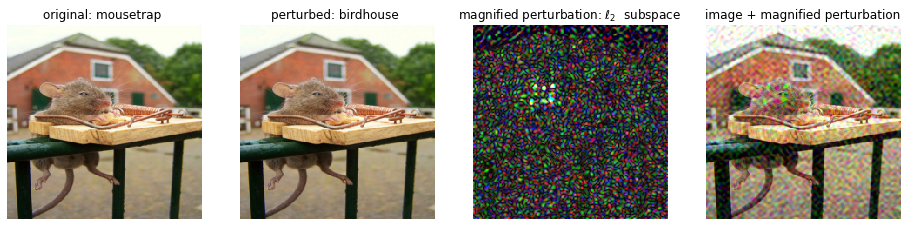

In [41]:
dist = 'l2'
Q_max = 25000
iteration = round(Q_max/500) 
q_opt_it = int(Q_max  - (iteration)*25)
q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
q_opt_it = int(Q_max  - (iterate)*25)
q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
print('#################################################################')
print('Start: The GeoDA will be run for:' + ' Iterations = ' + str(iterate) + ', Query = ' + str(Q_max) + ', Norm = ' + str(dist)+ ', Space = ' + str(search_space) )
print('#################################################################')


t3 = time.time()
x_adv, query_o, gradient, norm_p = GeoDA(x_b, iterate, q_opt_iter)
t4 = time.time()
message = ' took {:.5f} seconds'.format(t4 - t3)
qmessage = ' with query = ' + str(query_o + query_rnd)

x_opt_inverse = inv_tf(x_adv.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
norm_inv_opt = linalg.norm(x_opt_inverse-image_fb)


print('#################################################################')
print('End: The GeoDA algorithm' + message + qmessage )
print('#################################################################')


if dist == 'l2' or dist == 'linf':
    adv_label = torch.argmax(net.forward(Variable(x_adv, requires_grad=True)).data).item()
    str_label_adv = get_label(labels[np.int(adv_label)].split(',')[0])



    pert_norm = abs(x_opt_inverse-image_fb)/np.linalg.norm(abs(x_opt_inverse-image_fb))

    pert_norm_abs = (x_opt_inverse-image_fb)/np.linalg.norm((x_opt_inverse-image_fb))

    pertimage = image_fb + 30*pert_norm_abs


    fig, axes = plt.subplots(1, 4,figsize=(16,16))


    axes[0].imshow(image_fb)
    axes[1].imshow(x_opt_inverse)

    axes[3].imshow(pertimage)
    axes[2].imshow(100*pert_norm)

    axes[0].set_title('original: ' + str_label_orig )
    axes[1].set_title('perturbed: ' + str_label_adv)
    axes[2].set_title('magnified perturbation: $\ell_2$  subspace')
    axes[3].set_title('image + magnified perturbation' )
    
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    axes[3].axis('off')
    plt.show()

In [42]:
norm_p

[11.442123,
 8.412233,
 6.046024,
 4.305225,
 3.3623402,
 2.707158,
 2.263097,
 1.9467236,
 1.7042968,
 1.5063713,
 1.3504113,
 1.2250202,
 1.1247822,
 1.0412942,
 0.9698482]

In [43]:
q = np.array(norm_p)/(224*224*3)

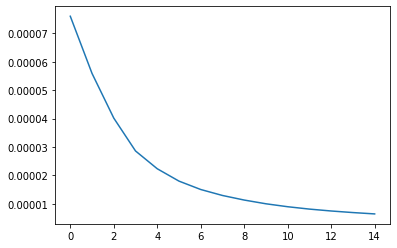

In [44]:
plt.plot(range(len(norm_p)), q)

# To run over several images we should have their paths and numbers

In [191]:
image_names_default

['./data/ILSVRC2012_val_00000420.JPEG',
 './data/ILSVRC2012_val_00000009.JPEG',
 './data/ILSVRC2012_val_00000502.JPEG',
 './data/ILSVRC2012_val_00000064.JPEG',
 './data/ILSVRC2012_val_00001069.JPEG']

In [ ]:
net = torch_models.resnet50(pretrained=True)
net = net.to(device)
net.eval()


In [193]:
image_nums = [420, 9, 502, 64, 69]

#################################################################
Start: The GeoDA will be run for: Iterations = 15, Query = 25000, Norm = l2, Space = sub
#################################################################
iteration -> 0 (took 0.58103 seconds)     -- l2 norm is -> 60.568607
iteration -> 1 (took 0.68606 seconds)     -- l2 norm is -> 45.6121
iteration -> 2 (took 0.87580 seconds)     -- l2 norm is -> 30.39337
iteration -> 3 (took 1.14607 seconds)     -- l2 norm is -> 22.855455
iteration -> 4 (took 1.49732 seconds)     -- l2 norm is -> 18.986845
iteration -> 5 (took 2.08650 seconds)     -- l2 norm is -> 15.8108
iteration -> 6 (took 2.65161 seconds)     -- l2 norm is -> 12.5833025
iteration -> 7 (took 3.95913 seconds)     -- l2 norm is -> 8.824215
iteration -> 8 (took 5.55060 seconds)     -- l2 norm is -> 6.3920827
iteration -> 9 (took 7.46680 seconds)     -- l2 norm is -> 4.882848
iteration -> 10 (took 10.29236 seconds)     -- l2 norm is -> 3.9064155
iteration -> 11 (took 14

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


#################################################################
End: The GeoDA algorithm took 148.14855 seconds with query = 25035
#################################################################


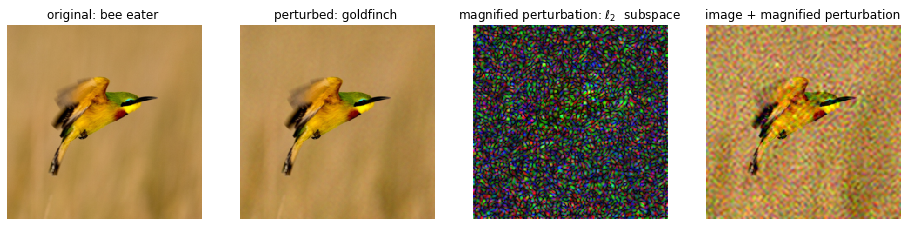

#################################################################
Start: The GeoDA will be run for: Iterations = 15, Query = 25000, Norm = l2, Space = sub
#################################################################
iteration -> 0 (took 0.50870 seconds)     -- l2 norm is -> 16.034876
iteration -> 1 (took 0.64049 seconds)     -- l2 norm is -> 9.564512
iteration -> 2 (took 0.81657 seconds)     -- l2 norm is -> 7.247293
iteration -> 3 (took 1.09722 seconds)     -- l2 norm is -> 5.687155
iteration -> 4 (took 1.46251 seconds)     -- l2 norm is -> 4.3910017
iteration -> 5 (took 1.92726 seconds)     -- l2 norm is -> 3.3434715
iteration -> 6 (took 2.67938 seconds)     -- l2 norm is -> 2.68055
iteration -> 7 (took 3.89671 seconds)     -- l2 norm is -> 2.2271047
iteration -> 8 (took 5.26802 seconds)     -- l2 norm is -> 1.9222349
iteration -> 9 (took 7.46278 seconds)     -- l2 norm is -> 1.6799184
iteration -> 10 (took 12.48433 seconds)     -- l2 norm is -> 1.5051979
iteration -> 11 (took 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


#################################################################
End: The GeoDA algorithm took 152.14771 seconds with query = 25003
#################################################################


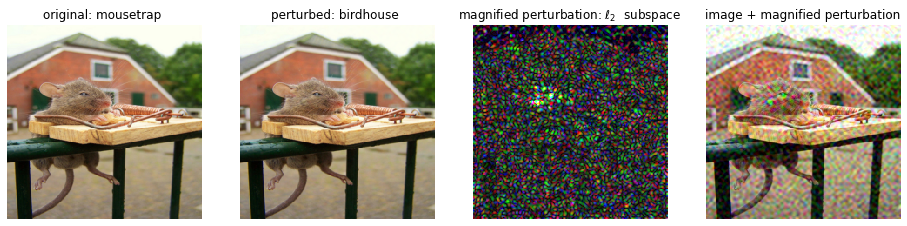

#################################################################
Start: The GeoDA will be run for: Iterations = 15, Query = 25000, Norm = l2, Space = sub
#################################################################
iteration -> 0 (took 0.54567 seconds)     -- l2 norm is -> 8.770197
iteration -> 1 (took 0.67328 seconds)     -- l2 norm is -> 3.6835768
iteration -> 2 (took 0.87508 seconds)     -- l2 norm is -> 2.1174672
iteration -> 3 (took 1.11211 seconds)     -- l2 norm is -> 1.351374
iteration -> 4 (took 1.45053 seconds)     -- l2 norm is -> 0.99218434
iteration -> 5 (took 1.98699 seconds)     -- l2 norm is -> 0.77458966
iteration -> 6 (took 2.60356 seconds)     -- l2 norm is -> 0.6360293
iteration -> 7 (took 3.85274 seconds)     -- l2 norm is -> 0.5390537
iteration -> 8 (took 5.35635 seconds)     -- l2 norm is -> 0.46865147
iteration -> 9 (took 7.39917 seconds)     -- l2 norm is -> 0.41480222
iteration -> 10 (took 11.13719 seconds)     -- l2 norm is -> 0.37287983
iteration -> 11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


#################################################################
End: The GeoDA algorithm took 150.98514 seconds with query = 25003
#################################################################


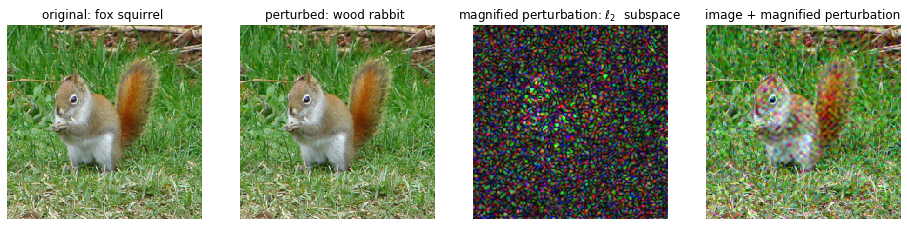

#################################################################
Start: The GeoDA will be run for: Iterations = 15, Query = 25000, Norm = l2, Space = sub
#################################################################
iteration -> 0 (took 0.52552 seconds)     -- l2 norm is -> 34.849083
iteration -> 1 (took 0.64879 seconds)     -- l2 norm is -> 21.256372
iteration -> 2 (took 0.79862 seconds)     -- l2 norm is -> 17.556593
iteration -> 3 (took 1.14967 seconds)     -- l2 norm is -> 13.619936
iteration -> 4 (took 1.44196 seconds)     -- l2 norm is -> 10.876577
iteration -> 5 (took 2.00184 seconds)     -- l2 norm is -> 9.059433
iteration -> 6 (took 2.67661 seconds)     -- l2 norm is -> 7.766451
iteration -> 7 (took 3.85980 seconds)     -- l2 norm is -> 6.543795
iteration -> 8 (took 5.46234 seconds)     -- l2 norm is -> 5.580255
iteration -> 9 (took 7.40238 seconds)     -- l2 norm is -> 4.854418
iteration -> 10 (took 10.61418 seconds)     -- l2 norm is -> 4.3330526
iteration -> 11 (took 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


#################################################################
End: The GeoDA algorithm took 153.04059 seconds with query = 25028
#################################################################


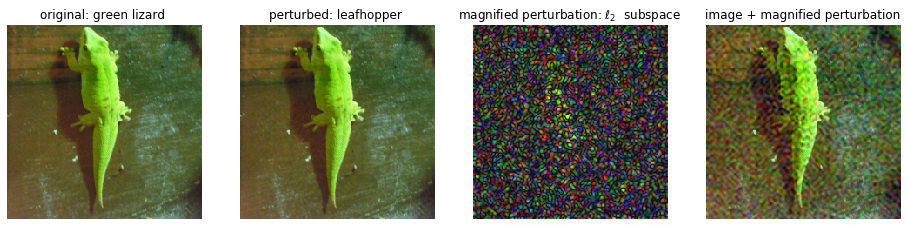

Already missclassified ... Lets try another one!
#################################################################
Start: The GeoDA will be run for: Iterations = 15, Query = 25000, Norm = l2, Space = sub
#################################################################
iteration -> 0 (took 0.55803 seconds)     -- l2 norm is -> 11.542612
iteration -> 1 (took 0.74944 seconds)     -- l2 norm is -> 7.541806
iteration -> 2 (took 0.84140 seconds)     -- l2 norm is -> 5.6069727
iteration -> 3 (took 1.15929 seconds)     -- l2 norm is -> 4.140882
iteration -> 4 (took 1.48002 seconds)     -- l2 norm is -> 3.3712456
iteration -> 5 (took 2.02036 seconds)     -- l2 norm is -> 2.801864
iteration -> 6 (took 2.60728 seconds)     -- l2 norm is -> 2.3924177
iteration -> 7 (took 3.72700 seconds)     -- l2 norm is -> 2.0771508
iteration -> 8 (took 5.21658 seconds)     -- l2 norm is -> 1.8432564
iteration -> 9 (took 6.83647 seconds)     -- l2 norm is -> 1.657607
iteration -> 10 (took 9.80793 seconds)     -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


#################################################################
End: The GeoDA algorithm took 150.48807 seconds with query = 25003
#################################################################


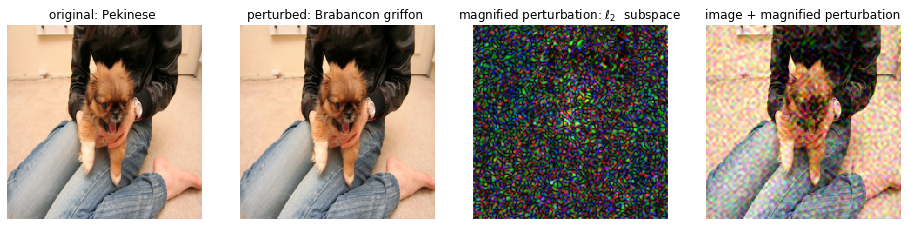

In [195]:
norms = []

for inp, image_num in zip(image_names_default, image_nums):

    t11 = time.time()

    im_orig = Image.open(inp)
    im_sz = 224
    im_orig = transforms.Compose([transforms.Resize((im_sz, im_sz))])(im_orig)


    image_fb = load_image(im_orig, data_format='channels_last')
    image_fb = image_fb / 255.  # because our model expects values in [0, 1]

    image_fb_first = load_image(im_orig, data_format='channels_first')
    image_fb_first = image_fb_first / 255.

    # Bounds for Validity and Perceptibility
    delta = 255
    lb, ub = valid_bounds(im_orig, delta)

        # Transform data

    im = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean,
                             std = std)])(im_orig)


    lb = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(lb)
    ub = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(ub)

    im_deepfool = im.to(device)
    lb = lb[None, :, :, :].to(device)
    ub = ub[None, :, :, :].to(device)

    x_0 = im[None, :, :, :].to(device)
    x_0_np = x_0.cpu().numpy()

    orig_label = torch.argmax(net.forward(Variable(x_0, requires_grad=True)).data).item()
    labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')
    str_label_orig = get_label(labels[np.int(orig_label)].split(',')[0])

    ground_truth  = open(os.path.join('val.txt'), 'r').read().split('\n')

    ground_name_label = ground_truth[image_num-1]
    ground_label_split_all =  ground_name_label.split

    ground_label_split =  ground_name_label.split()

    ground_label =  ground_name_label.split()[1]
    ground_label_int = int(ground_label)


    str_label_ground = get_label(labels[np.int(ground_label)].split(',')[0])


    #label_HSJA = np.argmax(fmodel.forward_one(image_fb_first))


    #str_HSJA_ground = get_label(labels[np.int(label_HSJA)].split(',')[0])

    if ground_label_int != int(orig_label):
        print('Already missclassified ... Lets try another one!')

    else:    
        image_iter = image_iter + 1

        x0_inverse = inv_tf(x_0.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
        dif_norm = linalg.norm(x0_inverse-image_fb)
        
    x_random, query_random_1 = find_random_adversarial(x_0, epsilon=100)

    x_rnd_inverse = inv_tf(x_random.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
    norm_rnd_inv = linalg.norm(x_rnd_inverse-image_fb)

    is_adversarial(x_random, orig_label)

    label_random = torch.argmax(net.forward(Variable(x_random, requires_grad=True)).data).item()


    # Binary search

    x_boundary, query_binsearch_2 = bin_search(x_0, x_random, tol)
    x_b = x_boundary


    Norm_rnd = torch.norm(x_0-x_boundary)      
    x_bin_inverse = inv_tf(x_boundary.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
    norm_bin_rnd = linalg.norm(x_bin_inverse-image_fb)


    x_rnd_BA = np.swapaxes(x_bin_inverse, 0, 2)
    x_rnd_BA = np.swapaxes(x_rnd_BA, 1, 2)



    is_adversarial(x_boundary, orig_label)

    label_boundary = torch.argmax(net.forward(Variable(x_boundary, requires_grad=True)).data).item()

    query_rnd = query_binsearch_2 + query_random_1
    
    dist = 'l2'
    Q_max = 25000
    iteration = round(Q_max/500) 
    q_opt_it = int(Q_max  - (iteration)*25)
    q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
    q_opt_it = int(Q_max  - (iterate)*25)
    q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
    print('#################################################################')
    print('Start: The GeoDA will be run for:' + ' Iterations = ' + str(iterate) + ', Query = ' + str(Q_max) + ', Norm = ' + str(dist)+ ', Space = ' + str(search_space) )
    print('#################################################################')


    t3 = time.time()
    x_adv, query_o, gradient, norm_p = GeoDA(x_b, iterate, q_opt_iter)
    t4 = time.time()
    
    norms.append(norm_p)
    
    
    message = ' took {:.5f} seconds'.format(t4 - t3)
    qmessage = ' with query = ' + str(query_o + query_rnd)

    x_opt_inverse = inv_tf(x_adv.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
    norm_inv_opt = linalg.norm(x_opt_inverse-image_fb)


    print('#################################################################')
    print('End: The GeoDA algorithm' + message + qmessage )
    print('#################################################################')


    if dist == 'l2' or dist == 'linf':
        adv_label = torch.argmax(net.forward(Variable(x_adv, requires_grad=True)).data).item()
        str_label_adv = get_label(labels[np.int(adv_label)].split(',')[0])



        pert_norm = abs(x_opt_inverse-image_fb)/np.linalg.norm(abs(x_opt_inverse-image_fb))

        pert_norm_abs = (x_opt_inverse-image_fb)/np.linalg.norm((x_opt_inverse-image_fb))

        pertimage = image_fb + 30*pert_norm_abs


        fig, axes = plt.subplots(1, 4,figsize=(16,16))


        axes[0].imshow(image_fb)
        axes[1].imshow(x_opt_inverse)

        axes[3].imshow(pertimage)
        axes[2].imshow(100*pert_norm)

        axes[0].set_title('original: ' + str_label_orig )
        axes[1].set_title('perturbed: ' + str_label_adv)
        axes[2].set_title('magnified perturbation: $\ell_2$  subspace')
        axes[3].set_title('image + magnified perturbation' )

        axes[0].axis('off')
        axes[1].axis('off')
        axes[2].axis('off')
        axes[3].axis('off')
        plt.show()


In [198]:
norms = np.array(norms)/(224*224*3)

In [199]:
norms.shape

(5, 15)

In [200]:
q = np.median(norms, axis = 0)
q

array([1.06524207e-04, 6.35397551e-05, 4.81458134e-05, 3.77813747e-05,
       2.91706639e-05, 2.22116253e-05, 1.78076511e-05, 1.47952850e-05,
       1.27699491e-05, 1.11601722e-05, 1.00050875e-05, 9.14511489e-06,
       8.43087442e-06, 7.82513937e-06, 7.29183445e-06])

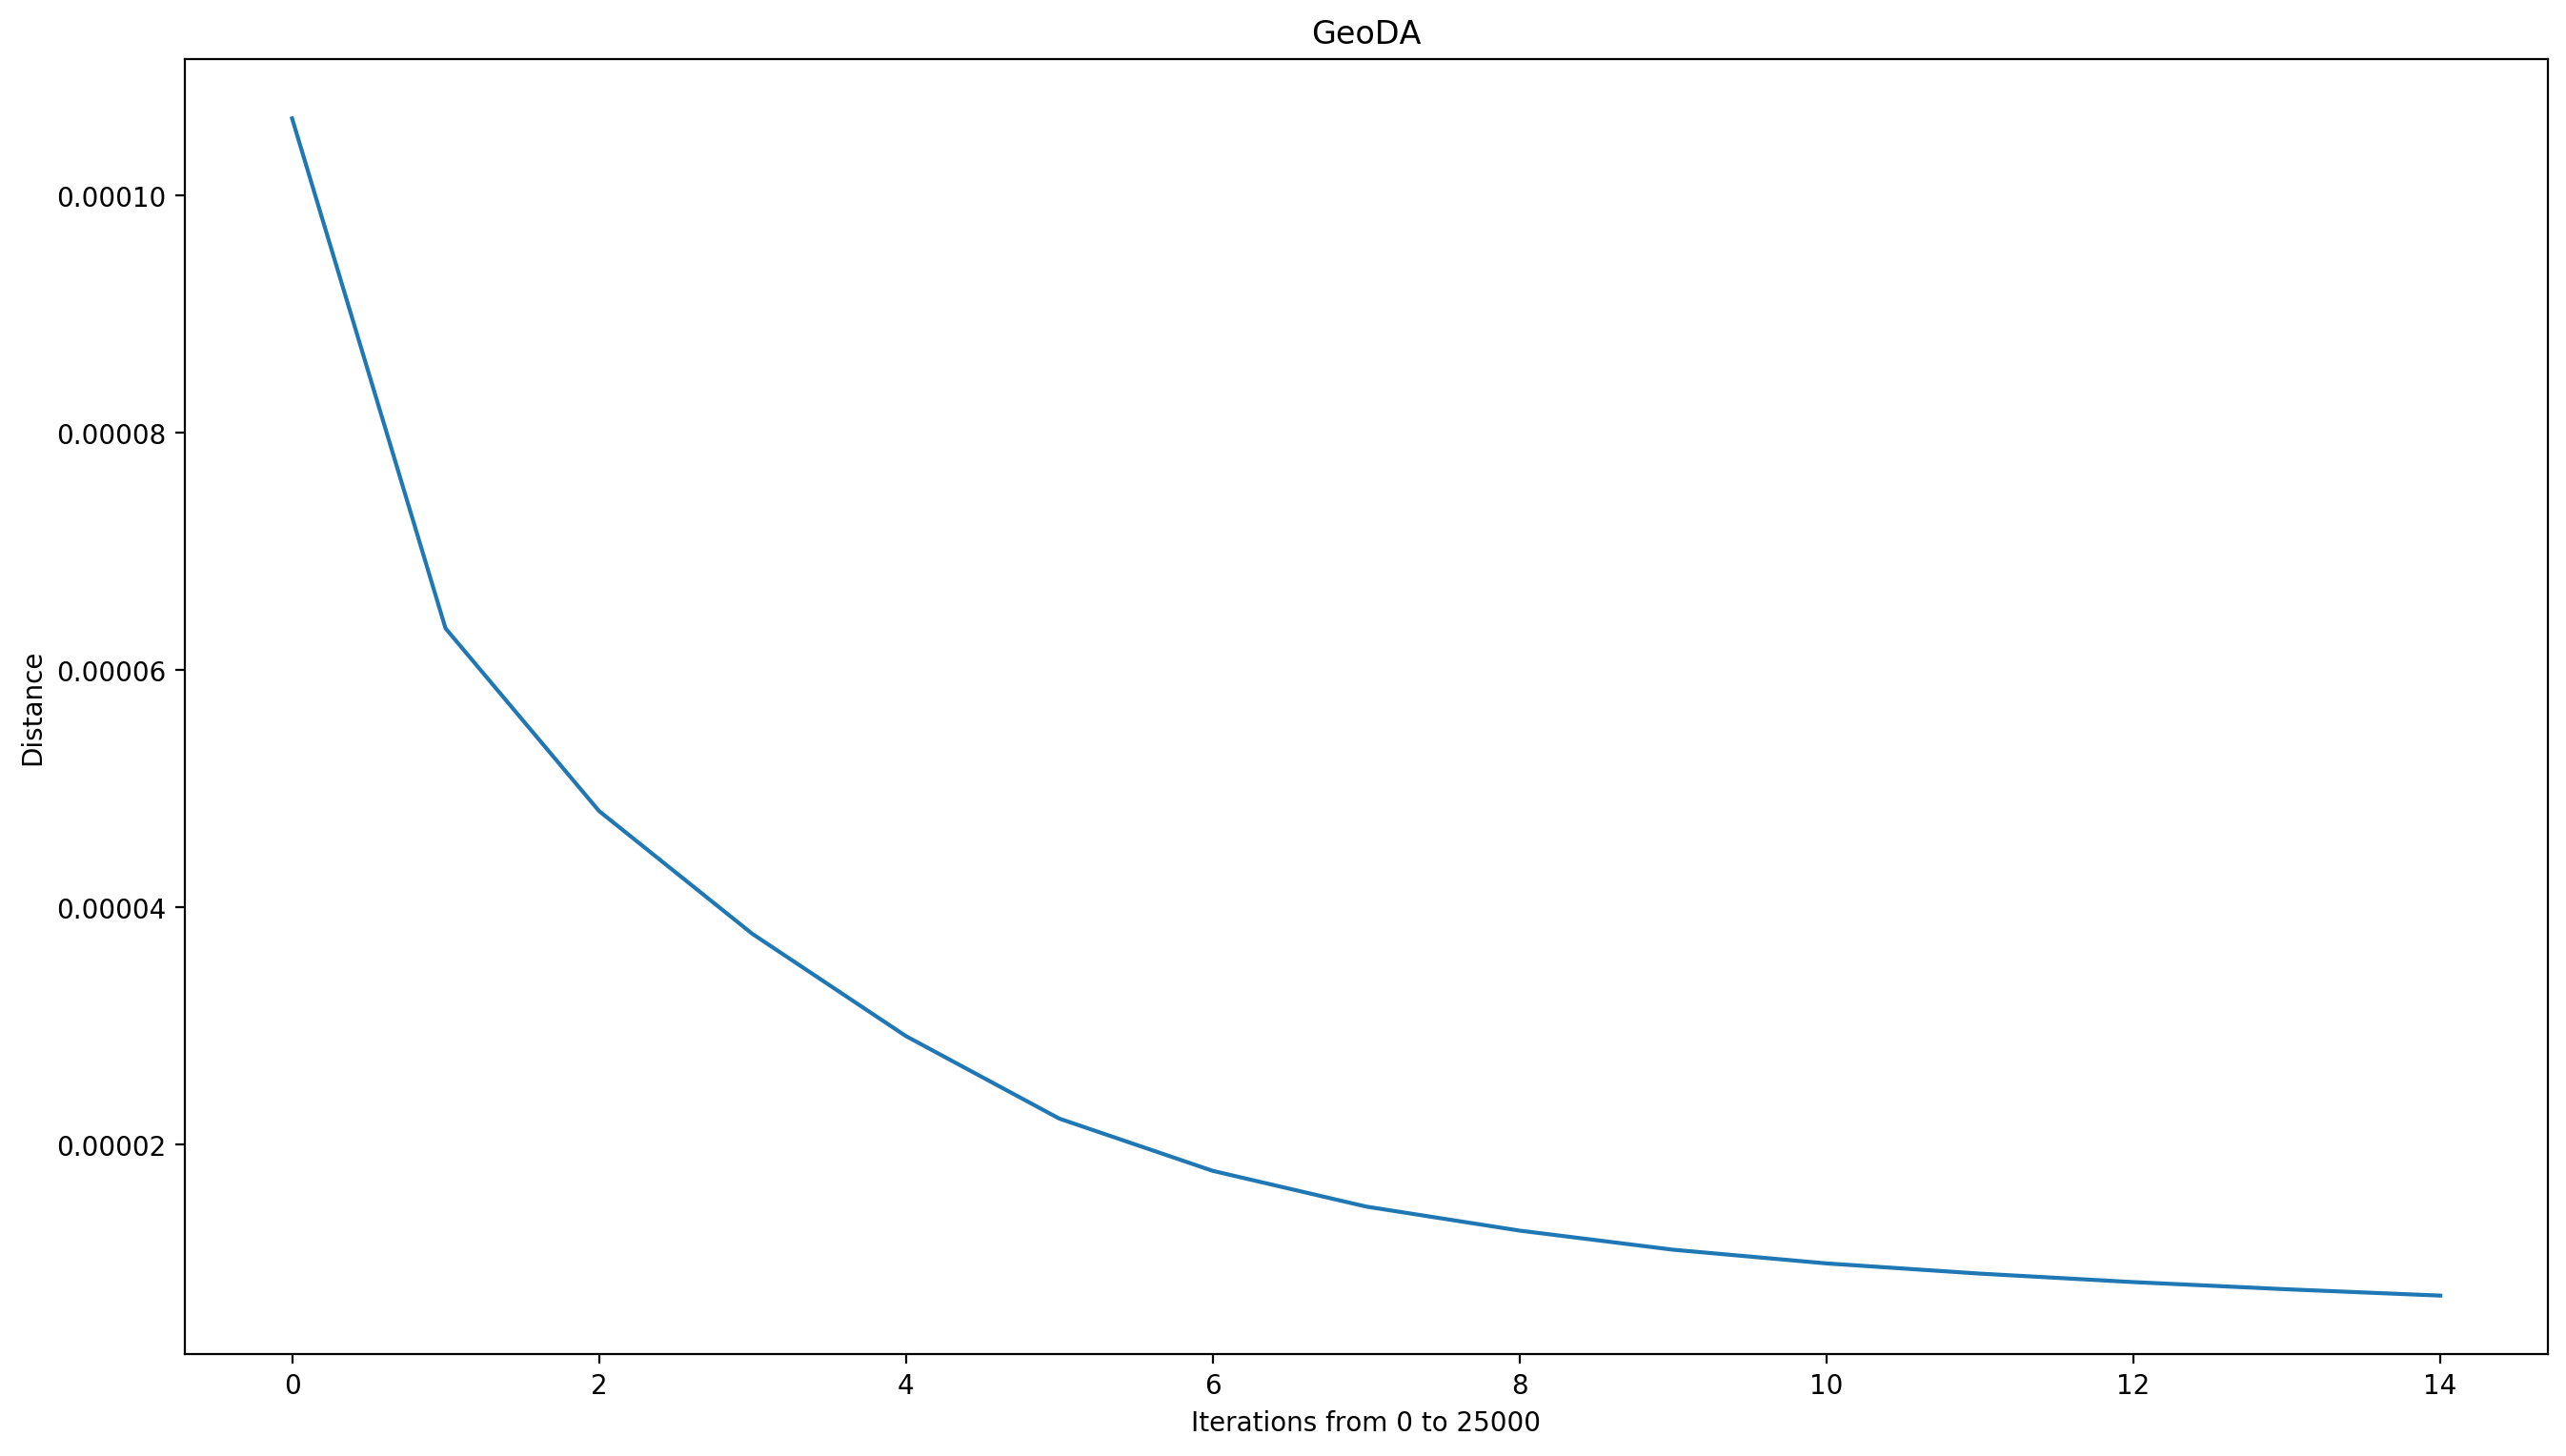

<Figure size 432x288 with 0 Axes>

In [220]:
plt.figure(figsize=(16,9), dpi=200)
plt.plot(range(len(q)), q)
plt.title('GeoDA')
plt.xlabel('Iterations from 0 to 25000')
plt.ylabel('Distance')
plt.show()
plt.savefig('geoda.png')

In [216]:
image_names

['./fotki/ILSVRC2012_val_00034435.jpeg',
 './fotki/ILSVRC2012_val_00006348.jpeg',
 './fotki/ILSVRC2012_val_00030034.jpeg',
 './fotki/ILSVRC2012_val_00000293.jpeg',
 './fotki/ILSVRC2012_val_00009745.jpeg',
 './fotki/ILSVRC2012_val_00002596.jpeg',
 './fotki/ILSVRC2012_val_00004606.jpeg',
 './fotki/ILSVRC2012_val_00000589.jpeg',
 './fotki/ILSVRC2012_val_00005278.jpeg',
 './fotki/ILSVRC2012_val_00039154.jpeg',
 './fotki/ILSVRC2012_val_00003258.jpeg',
 './fotki/ILSVRC2012_val_00004707.jpeg',
 './fotki/ILSVRC2012_val_00003486.jpeg',
 './fotki/ILSVRC2012_val_00017567.jpeg',
 './fotki/ILSVRC2012_val_00029428.jpeg',
 './fotki/ILSVRC2012_val_00001242.jpeg',
 './fotki/ILSVRC2012_val_00004552.jpeg',
 './fotki/ILSVRC2012_val_00006149.jpeg',
 './fotki/ILSVRC2012_val_00007967.jpeg',
 './fotki/ILSVRC2012_val_00023896.jpeg',
 './fotki/ILSVRC2012_val_00019426.jpeg',
 './fotki/ILSVRC2012_val_00006227.jpeg',
 './fotki/ILSVRC2012_val_00001730.jpeg',
 './fotki/ILSVRC2012_val_00020389.jpeg',
 './fotki/ILSVRC

In [217]:
image_nums1 = [34435, 6348, 30034,293,9745,2596,4606,589,5278,39154,3258,4707,3486,17567,29428,1242,4552,
             6149,7967,23896,19426,6227,1730,20389,2877,382,7618,26389,236,6737,5862,239,1602,1190,112,168,626,
             678,7047,1522,28684,30533,1076,9950,3735,1722,3262,3199,4107,1069]

In [214]:
image_names[9]

'./fotki/ILSVRC2012_val_00039154.jpeg'

## Strange error, I don't know why. Хотя по-отдельности каждая фотка работает

In [218]:
#norms = []

for inp, image_num in zip(image_names, image_nums1):
    #inp=image_names[9]
    #image_num = 39154
    t11 = time.time()

    im_orig = Image.open(inp)
    im_sz = 224
    im_orig = transforms.Compose([transforms.Resize((im_sz, im_sz))])(im_orig)


    image_fb = load_image(im_orig, data_format='channels_last')
    image_fb = image_fb / 255.  # because our model expects values in [0, 1]

    image_fb_first = load_image(im_orig, data_format='channels_first')
    image_fb_first = image_fb_first / 255.

    # Bounds for Validity and Perceptibility
    delta = 255
    lb, ub = valid_bounds(im_orig, delta)

        # Transform data

    im = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean,
                             std = std)])(im_orig)


    lb = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(lb)
    ub = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(ub)

    im_deepfool = im.to(device)
    lb = lb[None, :, :, :].to(device)
    ub = ub[None, :, :, :].to(device)

    x_0 = im[None, :, :, :].to(device)
    x_0_np = x_0.cpu().numpy()

    orig_label = torch.argmax(net.forward(Variable(x_0, requires_grad=True)).data).item()
    labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')
    str_label_orig = get_label(labels[np.int(orig_label)].split(',')[0])

    ground_truth  = open(os.path.join('val.txt'), 'r').read().split('\n')

    ground_name_label = ground_truth[image_num-1]
    ground_label_split_all =  ground_name_label.split

    ground_label_split =  ground_name_label.split()

    ground_label =  ground_name_label.split()[1]
    ground_label_int = int(ground_label)


    str_label_ground = get_label(labels[np.int(ground_label)].split(',')[0])


    #label_HSJA = np.argmax(fmodel.forward_one(image_fb_first))


    #str_HSJA_ground = get_label(labels[np.int(label_HSJA)].split(',')[0])

    if ground_label_int != int(orig_label):
        print('Already missclassified ... Lets try another one!')

    else:    
        image_iter = image_iter + 1

        x0_inverse = inv_tf(x_0.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
        dif_norm = linalg.norm(x0_inverse-image_fb)

Already missclassified ... Lets try another one!
Already missclassified ... Lets try another one!
Already missclassified ... Lets try another one!


IndexError: too many indices for array